<a href="https://colab.research.google.com/github/Dhaneesh02/fyp_SER/blob/mfcc/mfcc_Preprocessing_CNN_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Speech Emotion Recognition - Final year project


##  General import

In [ ]:
### General imports ###
import os
from glob import glob
import pickle
import itertools
from scipy.stats import zscore
from sklearn.model_selection import train_test_split
import random
import sys


## Package
import glob 
import keras
import IPython.display as ipd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objs as go
import plotly.offline as py
import plotly.tools as tls
import seaborn as sns
import scipy.io.wavfile
import tensorflow as tf
py.init_notebook_mode(connected=True)


## Keras
from keras import regularizers
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
from keras.callbacks import  History, ReduceLROnPlateau, CSVLogger
from keras.models import Model, Sequential
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.preprocessing import sequence
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.utils import np_utils


## Sklearn
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder


## Rest
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
from tqdm import tqdm

input_duration=3
# % pylab inline
### Graph imports ###
from PIL import Image
import librosa
### Audio import ###

import IPython
from IPython.display import Audio

## III. Set labels

In [ ]:
# RAVDESS Database
label_dict_ravdess = {'02': 'NEU', '03':'HAP', '04':'SAD', '05':'ANG', '06':'FEA', '07':'DIS', '08':'SUR'}
#data_visualistion
data_df = pd.DataFrame(columns=['path', 'source', 'actor', 'gender',
                                'intensity', 'statement', 'repetition', 'emotion'])
# Set audio files labels
def set_label_ravdess(audio_file, gender_differentiation):
    label = label_dict_ravdess.get(audio_file[6:8])
    if gender_differentiation == True:
        if int(audio_file[18:20])%2 == 0: # Female
            label = 'female_' + label
        if int(audio_file[18:20])%2 == 1: # Male
            label = 'male_' + label
    return label

## IV. Import audio files

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# !pip install librosa
import os 
print(os.getcwd())

/content


In [ ]:
# Start feature extraction
print("Import Data: START")

# Audio file path and names
# file_path = '../../Datas/RAVDESS/'
file_path = '/content/drive/MyDrive/FYP/RAVDESS/'

# Initialize features and labels list
signal = []
labels = []

# Sample rate (16.0 kHz)
sample_rate = 16000     

# Max pad length (3.0 sec)
max_pad_len = 49100

file_name_list=[]

#data_visualisation
count = 0

# Compute spectogram for all audio file
for index,ravdess in enumerate(os.listdir(file_path)):
    ravdess=file_path+ravdess+'/'
    file_names = os.listdir(ravdess)
    file_name_list+=file_names
    print(ravdess)
#         print(ravdess,file_name_list)
    for audio_index, audio_file in enumerate(file_names):
      if audio_file[6:8] in list(label_dict_ravdess.keys()):

        # Read audio file
        y, sr = librosa.core.load(ravdess + audio_file, sr=sample_rate, offset=0.5)  #y->audio time series

        # Z-normalization
        # Audio normalization is when you put constant gain to a recording so that you
        # can bring the average amplitude to the desired level. In other words,
        # it means changing the audio's overall volume to fixed amount.
        y = zscore(y)

        # Padding or truncated signal 
        # reducing the audio file duration to 3 s
        if len(y) < max_pad_len:    
            y_padded = np.zeros(max_pad_len)
            y_padded[:len(y)] = y
            y = y_padded
        elif len(y) > max_pad_len:
            y = np.asarray(y[:max_pad_len])

        # Add to signal list
        signal.append(y)

        # Set label
        labels.append(set_label_ravdess(audio_file, False))
        
        #data_visualisation
        nm = audio_file.split('.')[0].split('-')
        path = ravdess + audio_file
        src = int(nm[1])
        actor = int(nm[-1])
        emotion = int(nm[2])
        if int(actor)%2 == 0:
            gender = "female"
        else:
            gender = "male"
        
        if nm[3] == '01':
            intensity = 0
        else:
            intensity = 1
        
        if nm[4] == '01':
            statement = 0
        else:
            statement = 1
        
        if nm[5] == '01':
            repeat = 0
        else:
            repeat = 1
            
        data_df.loc[count] = [path, src, actor, gender, intensity, statement, repeat, emotion]
        count += 1
      # Print running...
    print("Import Data: RUNNING ... {} files".format(audio_index))


# Cast labels to array
labels = np.asarray(labels).ravel()
file_names = file_name_list
# Stop feature extraction
print("Import Data: END \n")
print("Number of audio files imported: {}".format(labels.shape[0]))
#data_visualisation
print("Number of audio files imported for data_visualisation: ",count)

Import Data: START
/content/drive/MyDrive/FYP/RAVDESS/Actor_08/
Import Data: RUNNING ... 59 files
/content/drive/MyDrive/FYP/RAVDESS/Actor_04/
Import Data: RUNNING ... 59 files
/content/drive/MyDrive/FYP/RAVDESS/Actor_07/
Import Data: RUNNING ... 59 files
/content/drive/MyDrive/FYP/RAVDESS/Actor_06/
Import Data: RUNNING ... 59 files
/content/drive/MyDrive/FYP/RAVDESS/Actor_09/
Import Data: RUNNING ... 59 files
/content/drive/MyDrive/FYP/RAVDESS/Actor_10/
Import Data: RUNNING ... 59 files
/content/drive/MyDrive/FYP/RAVDESS/Actor_05/
Import Data: RUNNING ... 59 files
/content/drive/MyDrive/FYP/RAVDESS/Actor_02/
Import Data: RUNNING ... 59 files
/content/drive/MyDrive/FYP/RAVDESS/Actor_03/
Import Data: RUNNING ... 59 files
/content/drive/MyDrive/FYP/RAVDESS/Actor_01/
Import Data: RUNNING ... 59 files
/content/drive/MyDrive/FYP/RAVDESS/Actor_16/
Import Data: RUNNING ... 59 files
/content/drive/MyDrive/FYP/RAVDESS/Actor_17/
Import Data: RUNNING ... 59 files
/content/drive/MyDrive/FYP/RAVDES

##V. Data_visualisation

1. Sample

In [ ]:
print (len(data_df))
data_df.head()

1344


,path,source,actor,gender,intensity,statement,repetition,emotion
0,/content/drive/MyDrive/FYP/RAVDESS/Actor_08/03...,1,8,female,1,1,1,2
1,/content/drive/MyDrive/FYP/RAVDESS/Actor_08/03...,1,8,female,0,1,1,2
2,/content/drive/MyDrive/FYP/RAVDESS/Actor_08/03...,1,8,female,1,0,1,6
3,/content/drive/MyDrive/FYP/RAVDESS/Actor_08/03...,1,8,female,1,1,1,4
4,/content/drive/MyDrive/FYP/RAVDESS/Actor_08/03...,1,8,female,0,0,1,5


2. Trim the silence voice

In [ ]:
filename = data_df.path[1021]
print (filename)
samples, sample_rate = librosa.load(filename)
print(sample_rate, samples)
aa , bb = librosa.effects.trim(samples, top_db=30)
print(aa, bb)

/content/drive/MyDrive/FYP/RAVDESS/Actor_15/03-01-06-01-01-02-15.wav
22050 [2.3435667e-05 2.3544339e-05 2.6794847e-05 ... 7.5505050e-06 6.8762574e-07
 0.0000000e+00]
[-2.88753334e-04  2.55453106e-05 -1.02110316e-04 ...  3.37682344e-04
  3.63755418e-04  3.84014769e-04] [22016 61440]


3. Plotting Mel Power Spectrogram

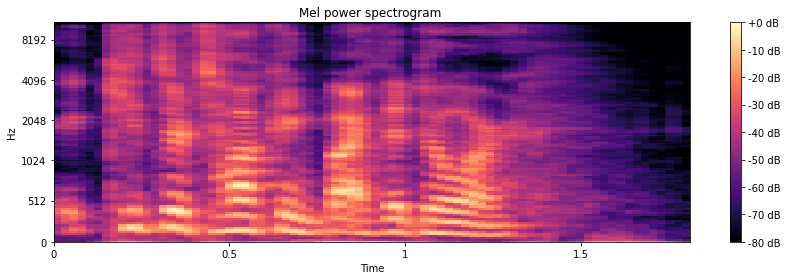

In [ ]:
S = librosa.feature.melspectrogram(aa, sr=sample_rate, n_mels=128)

# Convert to log scale (dB). We'll use the peak power (max) as reference.
log_S = librosa.power_to_db(S, ref=np.max)

plt.figure(figsize=(12, 4))
librosa.display.specshow(log_S, sr=sample_rate, x_axis='time', y_axis='mel')
plt.title('Mel power spectrogram ')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

4. All classes

In [ ]:

label8_list = []
for i in range(len(data_df)):
    if data_df.emotion[i] == 1:
        lb = "_neutral"
    elif data_df.emotion[i] == 2:
        lb = "_calm"
    elif data_df.emotion[i] == 3:
        lb = "_happy"
    elif data_df.emotion[i] == 4:
        lb = "_sad"
    elif data_df.emotion[i] == 5:
        lb = "_angry"
    elif data_df.emotion[i] == 6:
        lb = "_fearful"
    elif data_df.emotion[i] == 7:
        lb = "_disgust"
    elif data_df.emotion[i] == 8:
        lb = "_surprised"
    else:
        lb = "_none"
        
    # Add gender to the label 
    label8_list.append(data_df.gender[i]  + lb)
    
len(label8_list)

1344

5. Selecting the label set you want by commenting the unwanteds.





In [ ]:
data_df['label'] = label8_list
print (data_df.label.value_counts().keys())
data_df.head()

Index(['female_calm', 'female_fearful', 'female_sad', 'female_angry',
       'female_happy', 'female_disgust', 'female_surprised', 'male_calm',
       'male_surprised', 'male_happy', 'male_fearful', 'male_sad',
       'male_angry', 'male_disgust'],
      dtype='object')


,path,source,actor,gender,intensity,statement,repetition,emotion,label
0,/content/drive/MyDrive/FYP/RAVDESS/Actor_08/03...,1,8,female,1,1,1,2,female_calm
1,/content/drive/MyDrive/FYP/RAVDESS/Actor_08/03...,1,8,female,0,1,1,2,female_calm
2,/content/drive/MyDrive/FYP/RAVDESS/Actor_08/03...,1,8,female,1,0,1,6,female_fearful
3,/content/drive/MyDrive/FYP/RAVDESS/Actor_08/03...,1,8,female,1,1,1,4,female_sad
4,/content/drive/MyDrive/FYP/RAVDESS/Actor_08/03...,1,8,female,0,0,1,5,female_angry


6. Plotting the emotion distribution


In [ ]:

def plot_emotion_dist(dist, color_code='#C2185B', title="Plot"):
    """
    To plot the data distributioin by class.
    Arg:
      dist: pandas series of label count. 
    """
    tmp_df = pd.DataFrame()
    tmp_df['Emotion'] = list(dist.keys())
    tmp_df['Count'] = list(dist)
    fig, ax = plt.subplots(figsize=(14, 7))
    ax = sns.barplot(x="Emotion", y='Count', color=color_code, data=tmp_df)
    ax.set_title(title)
    ax.set_xticklabels(ax.get_xticklabels(),rotation=45)

7. Plotting

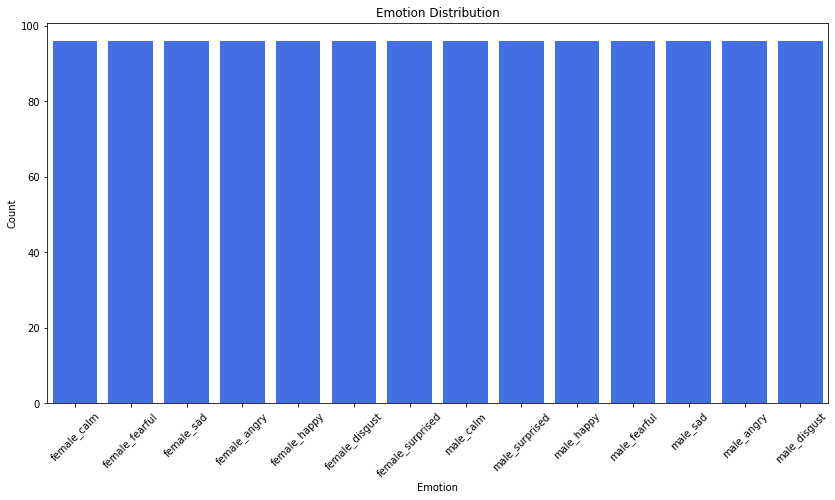

In [ ]:
a = data_df.label.value_counts()
plot_emotion_dist(a, "#2962FF", "Emotion Distribution")

8. Playing sample audio file

682 1344


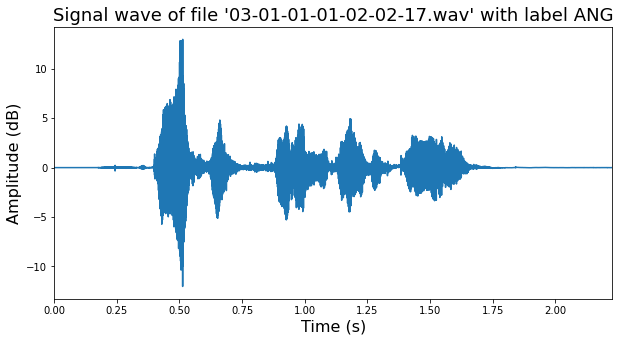

Audio file '03-01-01-01-02-02-17.wav':


In [ ]:
# Select one random audio file
random_idx = np.random.randint(len(labels))
random_label = labels[random_idx]
random_signal = signal[random_idx]
print(random_idx,len(labels))
# print(file_names)
random_filename = file_names[random_idx]
# Plot signal wave
plt.figure(figsize=(10,5))
plt.plot(np.arange(len(random_signal))/float(sample_rate), random_signal)
plt.xlim((np.arange(len(random_signal))/float(sample_rate))[0], (np.arange(len(random_signal))/float(sample_rate))[-1])
plt.xlabel('Time (s)', fontsize=16)
plt.ylabel('Amplitude (dB)', fontsize=16)
plt.title("Signal wave of file '{}' with label {}".format(random_filename, random_label), fontsize=18)
plt.show()

# Play audio file
print("Audio file '{}':".format(random_filename))
Audio(random_signal, rate=sample_rate)

## VI. Audio data augmentation

In [ ]:
# Number of augmented data
nb_augmented = 2

# Function to add noise to a signals with a desired Signal Noise ratio (SNR)
def noisy_signal(signal, snr_low=15, snr_high=30, nb_augmented=2):
    
    # Signal length
    signal_len = len(signal)

    # Generate White noise
    noise = np.random.normal(size=(nb_augmented, signal_len))
    
    # Compute signal and noise power
    s_power = np.sum((signal / (2.0 ** 15)) ** 2) / signal_len
    n_power = np.sum((noise / (2.0 ** 15)) ** 2, axis=1) / signal_len
    
    # Random SNR: Uniform [15, 30]
    snr = np.random.randint(snr_low, snr_high)
    
    # Compute K coeff for each noise
    K = np.sqrt((s_power / n_power) * 10 ** (- snr / 10))
    K = np.ones((signal_len, nb_augmented)) * K
    
    # Generate noisy signal
    return signal + K.T * noise

In [ ]:
# Generate noisy signals from signal list
print("Data Augmentation: START")
augmented_signal = list(map(noisy_signal, signal))
print("Data Augmentation: END!")

Data Augmentation: START
Data Augmentation: END!


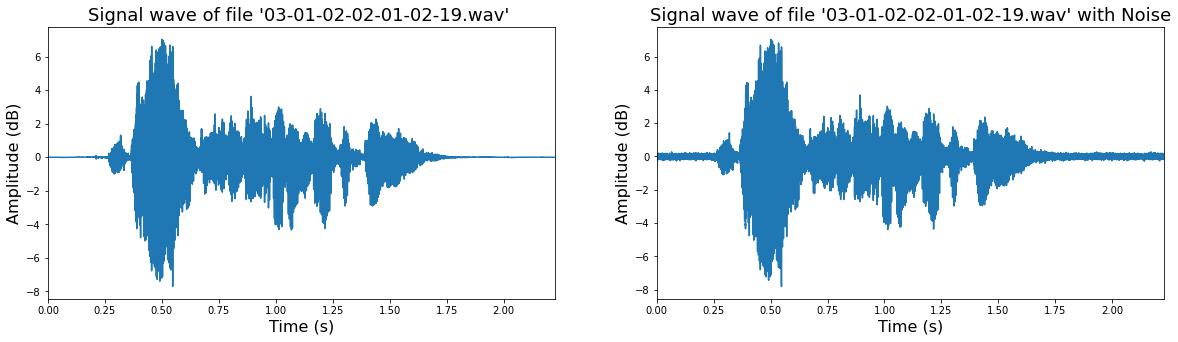

Audio file '03-01-02-02-01-02-19.wav':


Audio file '03-01-02-02-01-02-19.wav' with noise:


In [ ]:
# Plot signal wave
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.plot(np.arange(len(random_signal))/float(sample_rate), random_signal)
plt.xlim((np.arange(len(random_signal))/float(sample_rate))[0], (np.arange(len(random_signal))/float(sample_rate))[-1])
plt.xlabel('Time (s)', fontsize=16)
plt.ylabel('Amplitude (dB)', fontsize=16)
plt.title("Signal wave of file '{}' ".format(random_filename), fontsize=18)

# Plot signal wave with noise
plt.subplot(1,2,2)
plt.plot(np.arange(len(random_signal))/float(sample_rate), augmented_signal[random_idx][0])
plt.xlim((np.arange(len(random_signal))/float(sample_rate))[0], (np.arange(len(random_signal))/float(sample_rate))[-1])
plt.xlabel('Time (s)', fontsize=16)
plt.ylabel('Amplitude (dB)', fontsize=16)
plt.title("Signal wave of file '{}' with Noise".format(random_filename), fontsize=18)
plt.show()

# Play audio file
print("Audio file '{}':".format(random_filename))
IPython.display.display(Audio(random_signal, rate=sample_rate))

# Play same audio file with noise
print("Audio file '{}' with noise:".format(random_filename))
IPython.display.display(Audio(augmented_signal[random_idx][0], rate=sample_rate))

## VII. Feature extraction

In [ ]:
def mel_spectrogram(y, sr=16000, n_fft=512, win_length=256, hop_length=128, window='hamming', n_mels=128, fmax=4000):
    
    # Compute spectogram
    mel_spect = np.abs(librosa.stft(y, n_fft=n_fft, window=window, win_length=win_length, hop_length=hop_length)) ** 2
    
    # Compute mel spectrogram
    mel_spect = librosa.feature.melspectrogram(S=mel_spect, sr=sr, n_mels=n_mels, fmax=fmax)
    
    # Compute log-mel spectrogram
    mel_spect = librosa.power_to_db(mel_spect, ref=np.max)
    
    return mel_spect

In [ ]:
mfccs = tf.signal.mfccs_from_log_mel_spectrograms(
  log_mel_spectrograms)[..., :13]

In [ ]:
mel_spectrogram(random_signal[0])

(128, 384)

ParameterError: ignored

In [ ]:
# Start feature extraction
print("Feature extraction: START")

# Compute spectogram for all audio file
mel_spect = np.asarray(list(map(mel_spectrogram, signal)))
augmented_mel_spect = [np.asarray(list(map(mel_spectrogram, augmented_signal[i]))) for i in range(len(augmented_signal))]

# Stop feature extraction
print("Feature extraction: END!")

Feature extraction: START
Feature extraction: END!


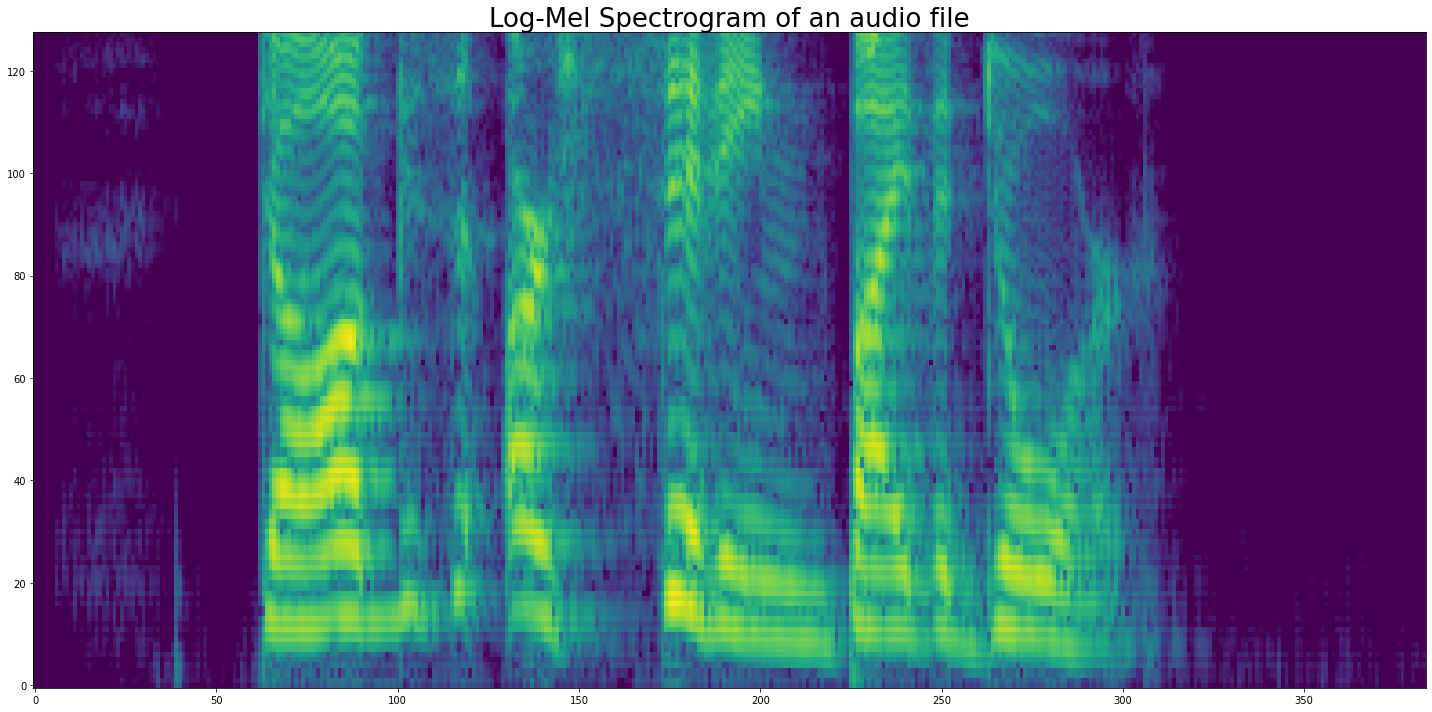

In [ ]:
# Plot one random Spectogram 
plt.figure(figsize=(20, 10))
plt.imshow(mel_spect[np.random.randint(len(mel_spect))], origin='lower', aspect='auto', cmap='viridis')
plt.title('Log-Mel Spectrogram of an audio file', fontsize=26)
plt.tight_layout()
plt.show()

## VIII. Train and test set

In [ ]:
# Build Train and test dataset
# MEL_SPECT_train, MEL_SPECT_test,  label_train, label_test = train_test_split(mel_spect,  labels, test_size=0.2)
MEL_SPECT_train, MEL_SPECT_test, AUG_MEL_SPECT_train, AUG_MEL_SPECT_test, label_train, label_test = train_test_split(mel_spect, augmented_mel_spect, labels, test_size=0.2)

# Build augmented labels and train
aug_label_train = np.asarray(list(itertools.chain.from_iterable([[label] * nb_augmented for label in label_train])))
AUG_MEL_SPECT_train = np.asarray(list(itertools.chain.from_iterable(AUG_MEL_SPECT_train)))
AUG_MEL_SPECT_test = np.asarray(list(itertools.chain.from_iterable(AUG_MEL_SPECT_test)))
aug_label_test = np.asarray(list(itertools.chain.from_iterable([[label] * nb_augmented for label in label_test])))
# print(AUG_MEL_SPECT_train.shape)
# print(AUG_MEL_SPECT_test.shape)
# Concatenate original and augmented
# X_train = MEL_SPECT_train
# y_train = label_train
X_train = np.concatenate((MEL_SPECT_train, AUG_MEL_SPECT_train))
y_train = np.concatenate((label_train, aug_label_train))

print("x_train: ",X_train.shape)
print("y_train: ",y_train.shape)
# Build test set
X_test = np.concatenate((MEL_SPECT_test, AUG_MEL_SPECT_test))
# X_test = MEL_SPECT_test
y_test = np.concatenate((label_test, aug_label_test))

print(X_test.shape)
print(y_test.shape)
# Delete
# del MEL_SPECT_train, AUG_MEL_SPECT_train, label_train, aug_label_train, AUG_MEL_SPECT_test, MEL_SPECT_test, label_test
# del mel_spect, augmented_mel_spect, labels

x_train:  (3225, 128, 384)
y_train:  (3225,)
(807, 128, 384)
(807,)


## XI. Time distributed framing

In [ ]:
win_ts = 128
hop_ts = 64

def frame(x, win_step=128, win_size=64):
    nb_frames = 1 + int((x.shape[2] - win_size) / win_step)
    frames = np.zeros((x.shape[0], nb_frames, x.shape[1], win_size)).astype(np.float32)
    for t in range(nb_frames):
        frames[:,t,:,:] = np.copy(x[:,:,(t * win_step):(t * win_step + win_size)]).astype(np.float32)
    return frames

X_train = frame(X_train, hop_ts, win_ts)
X_test = frame(X_test, hop_ts, win_ts)

## X. Save as

In [ ]:
# Save Train and test set
pickle.dump(X_train.astype(np.float16), open('/content/drive/MyDrive/Pickle/[RAVDESS][MEL_SPECT][X_train].p', 'wb'))
pickle.dump(y_train, open('/content/drive/MyDrive/Pickle/[RAVDESS][MEL_SPECT][y_train].p', 'wb'))
pickle.dump(X_test.astype(np.float16), open('/content/drive/MyDrive/Pickle/[RAVDESS][MEL_SPECT][X_test].p', 'wb'))
pickle.dump(y_test, open('/content/drive/MyDrive/Pickle/[RAVDESS][MEL_SPECT][y_test].p', 'wb'))